# Portugal - LSTM

# Instalando Dependências e Importando Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pylab as plt

# Série temporal do Covid19 em Portugal

In [ ]:
# importando  Dataset
df_pt = pd.read_csv("https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv")

In [ ]:
# Redefinindo o tipo do campo de data
df_pt['data'] = pd.to_datetime(df_pt['data'])
df_pt['data_dados'] = pd.to_datetime(df_pt['data_dados'])

In [ ]:
df_pt.head()

,data,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,...,obitos_acores,obitos_madeira,obitos_estrangeiro,recuperados_arsnorte,recuperados_arscentro,recuperados_arslvt,recuperados_arsalentejo,recuperados_arsalgarve,recuperados_acores,recuperados_madeira,recuperados_estrangeiro,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-02-26,2020-02-26,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,2020-02-27,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-28,2020-02-28,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,2020-02-29,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-03,2020-01-03,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pt.tail()

,data,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,...,obitos_acores,obitos_madeira,obitos_estrangeiro,recuperados_arsnorte,recuperados_arscentro,recuperados_arslvt,recuperados_arsalentejo,recuperados_arsalgarve,recuperados_acores,recuperados_madeira,recuperados_estrangeiro,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
725,2022-02-20,2022-02-20,3187389,1212803,475170,1129770,112722,129269,52938,74717,NaN,9360,2676699,20831,1788.0,116.0,NaN,NaN,505037.0,NaN,NaN,NaN,161897.0,169466.0,213004.0,214488.0,253900.0,235715.0,273940.0,230863.0,307484.0,246800.0,209413.0,171045.0,124326.0,108489.0,73627.0,64643.0,81770.0,43677.0,...,83,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,134.0,186.0,432.0,595.0,1318.0,1713.0,2797.0,7257.0,6234.0,9869.0,10962.0,NaN,NaN,489859.0,1672.0,2842.0,3853.1,3833.4,0.74,0.73
726,2022-02-21,2022-02-21,3193178,1214195,476041,1131931,112973,129651,53322,75065,NaN,5789,2696696,20866,1832.0,114.0,NaN,NaN,489997.0,NaN,NaN,NaN,162242.0,169890.0,213525.0,215037.0,254327.0,236044.0,274400.0,231231.0,307998.0,247185.0,209785.0,171288.0,124551.0,108668.0,73743.0,64762.0,81893.0,43765.0,...,85,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,136.0,187.0,433.0,598.0,1319.0,1715.0,2800.0,7270.0,6243.0,9888.0,10978.0,NaN,NaN,475616.0,1718.0,2844.0,2934.0,2890.9,0.71,0.70
727,2022-02-22,2022-02-22,3206281,1217470,479301,1135955,113829,130303,53797,75626,NaN,13103,2717509,20894,1763.0,111.0,NaN,NaN,474904.0,NaN,NaN,NaN,162895.0,170648.0,214732.0,216209.0,255215.0,236769.0,275353.0,231932.0,309190.0,247966.0,210652.0,171852.0,125159.0,109159.0,74175.0,65129.0,82379.0,44016.0,...,85,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,137.0,187.0,434.0,599.0,1319.0,1716.0,2805.0,7283.0,6249.0,9903.0,10991.0,NaN,NaN,467878.0,1652.0,2851.0,2934.0,2890.9,0.71,0.70
728,2022-02-23,2022-02-23,3219439,1220217,481948,1140700,114688,131220,54596,76070,NaN,13158,2732009,20922,1646.0,101.0,NaN,NaN,459334.0,NaN,NaN,NaN,163603.0,171366.0,216043.0,217439.0,256316.0,237599.0,276356.0,232667.0,310335.0,248731.0,211436.0,172416.0,125690.0,109556.0,74557.0,65452.0,82773.0,44240.0,...,85,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,137.0,187.0,435.0,601.0,1320.0,1716.0,2808.0,7298.0,6255.0,9920.0,11002.0,NaN,NaN,466508.0,1545.0,2864.0,2533.7,2470.4,0.72,0.70
729,2022-02-24,2022-02-24,3231075,1222707,484522,1144337,115463,131959,55455,76632,NaN,11636,2741600,20941,1560.0,106.0,NaN,NaN,448694.0,NaN,NaN,NaN,164141.0,171921.0,217207.0,218489.0,257259.0,238335.0,277356.0,233307.0,311409.0,249501.0,212108.0,172881.0,126179.0,109918.0,74894.0,65730.0,83130.0,44438.0,...,85,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,137.0,187.0,437.0,603.0,1320.0,1717.0,2809.0,7305.0,6261.0,9930.0,11011.0,NaN,NaN,468534.0,1454.0,2872.0,2533.7,2470.4,0

In [ ]:
df_pt[df_pt['data'] == '2021-06-01']['internados']

315    3293.0
Name: internados, dtype: float64

In [ ]:
start_date = '2020-02-26'
final_date = '2022-01-31'

In [ ]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 93 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   data                               730 non-null    datetime64[ns]
 1   data_dados                         730 non-null    datetime64[ns]
 2   confirmados                        730 non-null    int64         
 3   confirmados_arsnorte               730 non-null    int64         
 4   confirmados_arscentro              730 non-null    int64         
 5   confirmados_arslvt                 730 non-null    int64         
 6   confirmados_arsalentejo            730 non-null    int64         
 7   confirmados_arsalgarve             730 non-null    int64         
 8   confirmados_acores                 730 non-null    int64         
 9   confirmados_madeira                730 non-null    int64         
 10  confirmados_estrangeiro            16 

In [ ]:
round(df_pt.describe(), 2)

,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,...,obitos_acores,obitos_madeira,obitos_estrangeiro,recuperados_arsnorte,recuperados_arscentro,recuperados_arslvt,recuperados_arsalentejo,recuperados_arsalgarve,recuperados_acores,recuperados_madeira,recuperados_estrangeiro,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,16.00,730.00,730.00,730.00,722.00,713.00,164.00,173.00,723.00,155.00,15.00,167.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.00,723.0,723.00,723.00,167.00,167.00,...,730.00,730.00,31.0,10.00,10.0,10.00,10.0,10.0,10.0,10.0,10.0,702.00,702.00,702.00,702.00,702.00,702.00,702.00,702.00,702.00,702.00,702.00,702.00,701.00,701.00,701.00,701.00,701.00,701.00,703.00,703.00,76.00,76.00,725.00,725.00,674.00,345.00,345.00,345.00,345.00
mean,683459.44,269426.95,93598.27,258582.50,23451.25,23240.38,5797.66,9362.22,9.12,4426.13,600417.40,10654.34,1243.53,193.57,2210.07,258703.39,81811.89,254759.04,12.20,640.63,22745.46,23742.05,36230.80,36079.44,55312.00,51410.57,55143.60,47798.73,63355.20,51046.00,52945.85,42220.81,33124.06,30161.53,21244.26,18866.2,31161.21,15698.45,0.44,0.34,...,28.09,46.74,0.0,10.80,9.1,13.90,0.0,0.0,0.0,0.0,0.0,0.79,0.84,0.73,0.62,3.47,4.87,12.37,14.84,42.17,64.18,91.51,220.46,303.16,691.05,881.58,1468.84,3939.51,3326.42,5273.35,5790.10,27.22,20.05,72886.93,1047.93,664.54,871.75,872.38,1.03,1.03
std,674639.24,255252.12,97284.69,249789.34,23931.22,27321.99,9042.92,15038.62,5.86,9979.55,576848.90,7778.82,1370.96,192.51,1387.71,157914.29,123371.52,123634.45,7.69,249.60,30622.47,31995.27,41899.66,42155.14,54583.62,51908.68,56057.22,48483.17,63519.18,51655.63,47481.18,38803.97,28969.72,26004.97,17748.64,15698.0,23206.97,11912.98,0.11,0.11,...,16.86,47.64,0.0,6.71,1.2,4.48,0.0,0.0,0.0,0.0,0.0,0.41,0.85,0.64,0.49,2.25,3.33,8.79,11.79,28.67,45.01,63.62,151.91,213.11,483.44,617.18,1034.49,2679.02,2294.13,3611.65,4024.23,14.59,9.23,120431.92,1188.99,1070.06,1721.24,1721.77,0.13,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00,9.00,30.00,25.00,81.00,1746.00,4.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.0,0.00,0.00,0.10,0.15,...,0.00,0.00,0.0,3.00,7.0,4.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,4.00,0.00,5.00,9.00,12.00,10.00,23.00,0.00,0.00,2.00,0.00,-152.00,50.30,47.50,0.71,0.70
25%,56373.25,20170.25,4708.50,29192.50,907.50,1046.00,205.75,142.75,5.00,389.25,41227.25,1807.50,408.50,70.00,1417.75,115158.00,25932.50,189274.00,6.00,707.00,1011.00,1156.00,1472.00,1334.50,4832.00,4258.00,5002.50,4520.00,5225.50,4310.00,4871.50,3727.50,3030.50,2732.00,2093.00,1867.0,4292.50,2072.50,0.36,0.28,...,15.00,0.00,0.0,3.00,8.0,11.00,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00,1.00,1.00,3.00,1.00,10.00,12.00,17.00,41.00,51.00,112.00,148.0

## Ajustando as Features

### Excluindo features 

In [ ]:
df_pt = df_pt.drop(['data_dados', 'confirmados_estrangeiro', 'cadeias_transmissao', 
                    'obitos_estrangeiro','recuperados_arscentro','recuperados_arslvt',
                    'recuperados_arsalentejo','recuperados_arsalgarve','recuperados_acores', 'recuperados_arsnorte',
                    'recuperados_madeira','recuperados_estrangeiro','obitos_arsnorte',
                    'obitos_arscentro','obitos_arslvt','obitos_arsalentejo','obitos_arsalgarve',
                    'obitos_acores','obitos_madeira','confirmados_arsnorte', 'confirmados_arscentro',
                    'confirmados_arslvt', 'confirmados_arsalentejo','confirmados_arsalgarve', 'confirmados_acores', 
                    'confirmados_madeira', 'transmissao_importada', 'confirmados_desconhecidos', 
                    'confirmados_desconhecidos_m', 'confirmados_desconhecidos_f'
                   ], axis=1)

In [ ]:
df_pt.shape

(730, 63)

In [ ]:
df_pt.columns

Index(['data', 'confirmados', 'confirmados_novos', 'recuperados', 'obitos',
       'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia',
       'n_confirmados', 'confirmados_0_9_f', 'confirmados_0_9_m',
       'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_f',
       'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
       'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f',
       'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m',
       'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f',
       'confirmados_80_plus_m', 'sintomas_tosse', 'sintomas_febre',
       'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia',
       'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada',
       'confirmados_f', 'confirmados_m', 'obitos_0_9_f', 'obitos_0_9_m',
       'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
       'obitos_30_39_f', 'obitos_30_39_m', 'obit

### Redefinindo algumas features utilizando a primeira diferença
* O objetivo é transformar os valores que representam o quantitativo acumulado diariamente no quantitativo diário

In [ ]:
# Fazendo cópia do Dataset orginal
df_pt_diff = df_pt.copy()
df_pt_diff.shape

(730, 63)

A coluna 'confirmados_0_9_m' possui uma lacuna em uma data crucial para os resultados por isso, está sendo feito o tratamento do NAN nesta coluna antes da aplicação da primeira diferença. A lacuna é para o registro 424 correspondente a data 2021-04-25

In [ ]:
df_pt_diff[df_pt_diff['confirmados_0_9_m'].isna()]

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-02-26,0,0,0,0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,0,0,0,0,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-28,0,0,0,0,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,0,0,0,0,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-03,0,0,0,0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-02-03,2,2,0,0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN
424,2021-04-25,834442,478,792685,16965,348.0,98.0,NaN,NaN,24313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455613.0,378523.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8056.0,8909.0,24792.0,250.0,72.1,68.3,0.98,0.99


In [ ]:
df_pt_diff.dropna(subset=['confirmados_0_9_m'], axis=0,inplace=True)
df_pt_diff.reset_index(inplace=True, drop=True)

In [ ]:
df_pt_diff.shape

(723, 63)

In [ ]:
df_pt_diff.head()

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-03-03,4,2,0,0,NaN,NaN,NaN,101.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50,0.50,NaN,0.25,0.50,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN
1,2020-04-03,6,2,0,0,NaN,NaN,NaN,117.0,81.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50,0.83,NaN,0.50,0.50,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,NaN,NaN,NaN,NaN
2,2020-05-03,9,3,0,0,9.0,NaN,NaN,147.0,213.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.67,0.89,0.11,0.33,0.56,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN
3,2020-06-03,13,4,0,0,13.0,NaN,30.0,181.0,354.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.62,0.85,0.15,0.23,0.46,0.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0.0,NaN,NaN,NaN,NaN
4,2020-07-03,21,8,0,0,21.0,NaN,47.0,224.0,412.0,NaN,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0,6.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.71,0.62,0.14,0.43,0.48,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# Cálculo da primeira diferença

features_list_diff = ['recuperados','obitos','suspeitos','n_confirmados','confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f',
                      'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
                      'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f', 'confirmados_50_59_m', 'confirmados_60_69_f',
                      'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m',
                      'confirmados_f', 'confirmados_m', 'obitos_f', 'obitos_m'
                    ]

for col in features_list_diff:
  temp = df_pt_diff.loc[0,col]
  df_pt_diff[col] = df_pt_diff[col].diff()
  df_pt_diff.loc[0,col] = temp

In [ ]:
df_pt_diff = df_pt_diff.sort_values(by='data') #, ascending=False)
df_pt_diff.reset_index(inplace=True, drop=True)
df_pt_diff.head()

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-01-04,8251,808,0.0,27.0,726.0,230.0,4957.0,7371.0,20275.0,6216.0,5.0,5.0,12.0,9.0,33.0,37.0,67.0,38.0,81.0,56.0,67.0,63.0,56.0,49.0,36.0,39.0,92.0,63.0,0.61,0.49,0.19,0.29,0.33,0.24,449.0,359.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,1.0,16.0,14.0,27.0,58.0,62.0,12.0,15.0,8021.0,496.0,NaN,NaN,NaN,NaN
1,2020-01-05,24987,295,128.0,18.0,892.0,154.0,3828.0,3562.0,29756.0,3233.0,0.0,4.0,7.0,6.0,17.0,27.0,34.0,19.0,22.0,31.0,35.0,18.0,7.0,12.0,6.0,4.0,38.0,8.0,0.44,0.34,0.15,0.20,0.25,0.18,166.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,9.0,22.0,32.0,56.0,81.0,116.0,387.0,294.0,9.0,9.0,22333.0,738.0,NaN,NaN,NaN,NaN
2,2020-01-06,32700,200,143.0,14.0,471.0,64.0,1720.0,1252.0,27958.0,1348.0,10.0,8.0,4.0,6.0,28.0,20.0,21.0,14.0,9.0,11.0,12.0,10.0,12.0,11.0,8.0,2.0,14.0,0.0,0.40,0.29,0.11,0.20,0.21,0.15,118.0,82.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,10.0,14.0,31.0,43.0,83.0,111.0,165.0,548.0,410.0,7.0,7.0,11724.0,407.0,NaN,NaN,NaN,NaN
3,2020-01-07,42523,352,293.0,3.0,503.0,79.0,1450.0,2381.0,31389.0,2033.0,1.0,13.0,13.0,6.0,40.0,36.0,44.0,34.0,17.0,30.0,19.0,20.0,15.0,24.0,6.0,11.0,13.0,5.0,0.37,0.28,0.10,0.20,0.21,0.15,170.0,182.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8.0,10.0,15.0,35.0,46.0,98.0,121.0,183.0,600.0,459.0,2.0,1.0,13146.0,424.0,NaN,NaN,NaN,NaN
4,2020-01-08,51310,238,300.0,2.0,375.0,40.0,1631.0,1887.0,35661.0,1668.0,12.0,12.0,13.0,6.0,15.0,17.0,18.0,19.0,19.0,17.0,13.0,14.0,16.0,7.0,5.0,8.0,17.0,10.0,0.35,0.27,0.10,0.20,0.21,0.14,128.0,110.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,10.0,10.0,17.0,38.0,48.0,106.0,130.0,207.0,660.0,505.0,1.0,1.0,12790.0,335.0,NaN,NaN,NaN,NaN


In [ ]:
df_pt_diff.tail()

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
718,2022-10-02,3025421,27651,17526.0,47.0,2366.0,168.0,NaN,NaN,638788.0,NaN,1518.0,1599.0,2535.0,2377.0,2296.0,1865.0,2377.0,1915.0,2563.0,1944.0,1483.0,1080.0,1025.0,783.0,619.0,608.0,695.0,353.0,NaN,NaN,NaN,NaN,NaN,NaN,15111.0,12524.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,182.0,422.0,579.0,1294.0,1675.0,2742.0,7119.0,6097.0,24.0,23.0,616785.0,2198.0,6562.1,6610.1,0.92,0.92
719,2022-11-01,1693398,33340,43513.0,28.0,1564.0,153.0,NaN,NaN,224730.0,NaN,1080.0,1201.0,1939.0,1937.0,2862.0,2705.0,2881.0,2630.0,3484.0,2887.0,2696.0,2394.0,1375.0,1268.0,657.0,625.0,381.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,17355.0,15929.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,117.0,166.0,396.0,541.0,1224.0,1576.0,2591.0,6692.0,5710.0,12.0,16.0,269451.0,1411.0,3204.4,3209.1,1.24,1.24
720,2022-11-02,3049692,24271,40691.0,41.0,2332.0,159.0,NaN,NaN,628109.0,NaN,1268.0,1418.0,2124.0,2112.0,1897.0,1621.0,2151.0,1738.0,2301.0,1585.0,1309.0,967.0,904.0,691.0,606.0,542.0,688.0,336.0,NaN,NaN,NaN,NaN,NaN,NaN,13248.0,11010.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,183.0,423.0,580.0,1296.0,1677.0,2750.0,7130.0,6112.0,15.0,26.0,600324.0,2173.0,6099.6,6133.0,0.88,0.88
721,2022-12-01,1734343,40945,33482.0,20.0,1635.0,167.0,NaN,NaN,236992.0,NaN,1474.0,1653.0,2479.0,2448.0,3525.0,3193.0,3640.0,3232.0,4280.0,3537.0,3212.0,2810.0,1545.0,1437.0,822.0,700.0,555.0,344.0,NaN,NaN,NaN,NaN,NaN,NaN,21532.0,19354.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,118.0,166.0,396.0,541.0,1225.0,1577.0,2594.0,6699.0,5717.0,8.0,12.0,276894.0,1468.0,3615.9,3615.3,1.23,1.23
722,2022-12-02,3069128,19436,34497.0,50.0,2232.0,160.0,NaN,NaN,615777.0,NaN,1100.0,1089.0,1715.0,1614.0,1476.0,1281.0,1668.0,1228.0,1754.0,1276.0,1122.0,818.0,786.0,603.0,523.0,476.0,581.0,319.0,NaN,NaN,NaN,NaN,NaN,NaN,10725.0,8704.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,130.0,183.0,423.0,582.0,1300.0,1678.0,2759.0,7150.0,6125.0,23.0,27.0,585213.0,2072.0,6099.6,6133.0,0.88,0.88


In [ ]:
# Verificação da existência de valores negativos após o cálculo da primeira diferença.
# Isso pode ocorrer devido aos erros de preenchimento do dataset

neg_cols = []

for col in features_list_diff:
  neg_check = df_pt_diff[df_pt_diff[col] < 0][col].count()

  if neg_check > 0:
    neg_cols.append(col)
    print(col,'--->',neg_check)
print('\nLista de colunas com valores negativos: \n', neg_cols)

confirmados_0_9_f ---> 8
confirmados_0_9_m ---> 6
confirmados_10_19_f ---> 3
confirmados_10_19_m ---> 4
confirmados_20_29_m ---> 2
confirmados_30_39_f ---> 1
confirmados_30_39_m ---> 1
confirmados_40_49_f ---> 2
confirmados_60_69_f ---> 1
confirmados_60_69_m ---> 2
confirmados_70_79_f ---> 3
confirmados_70_79_m ---> 3
confirmados_80_plus_f ---> 1
confirmados_80_plus_m ---> 3

Lista de colunas com valores negativos: 
 ['confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m', 'confirmados_40_49_f', 'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m']


In [ ]:
# Substituindo registros negativos pela mediana

print('Valores substituídos e mediana das colunas: \n')

for col in neg_cols:
  median_col = df_pt_diff[df_pt_diff[col] > 0][col].median()

  subs_list = df_pt_diff[df_pt_diff[col] < 0][col].to_list()
  print(col, '---> ', subs_list, '---> mediana: ', median_col)

  df_pt_diff[col] = df_pt_diff[col].replace(to_replace=subs_list, value=median_col)

Valores substituídos e mediana das colunas: 

confirmados_0_9_f --->  [-1.0, -1.0, -5.0, -2.0, -3.0, -1.0, -9.0, -1.0] ---> mediana:  42.0
confirmados_0_9_m --->  [-6.0, -5.0, -5.0, -7.0, -1.0, -4.0] ---> mediana:  43.0
confirmados_10_19_f --->  [-1.0, -6.0, -2.0] ---> mediana:  47.5
confirmados_10_19_m --->  [-4.0, -2.0, -5.0, -3.0] ---> mediana:  52.0
confirmados_20_29_m --->  [-118.0, -5.0] ---> mediana:  82.0
confirmados_30_39_f --->  [-5.0] ---> mediana:  72.0
confirmados_30_39_m --->  [-192.0] ---> mediana:  68.5
confirmados_40_49_f --->  [-2.0, -4.0] ---> mediana:  78.0
confirmados_60_69_f --->  [-14.0] ---> mediana:  48.0
confirmados_60_69_m --->  [-6.0, -9.0] ---> mediana:  40.0
confirmados_70_79_f --->  [-9.0, -1.0, -2.0] ---> mediana:  31.0
confirmados_70_79_m --->  [-5.0, -1.0, -4.0] ---> mediana:  27.5
confirmados_80_plus_f --->  [-1.0] ---> mediana:  37.0
confirmados_80_plus_m --->  [-2.0, -1.0, -1.0] ---> mediana:  20.0


### Criando novas features baseadas na coluna data

In [ ]:
# Criando novas features baseadas na coluna 'date'
df_pt_diff['dia'] = df_pt_diff['data'].dt.day
df_pt_diff['mes'] = df_pt_diff['data'].dt.month
#df_pt_diff['ano'] = df_pt_diff['data'].dt.year
df_pt_diff['dia_da_semana'] = df_pt_diff['data'].dt.dayofweek

In [ ]:
df_pt_diff.columns

Index(['data', 'confirmados', 'confirmados_novos', 'recuperados', 'obitos',
       'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia',
       'n_confirmados', 'confirmados_0_9_f', 'confirmados_0_9_m',
       'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_f',
       'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
       'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f',
       'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m',
       'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f',
       'confirmados_80_plus_m', 'sintomas_tosse', 'sintomas_febre',
       'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia',
       'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada',
       'confirmados_f', 'confirmados_m', 'obitos_0_9_f', 'obitos_0_9_m',
       'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
       'obitos_30_39_f', 'obitos_30_39_m', 'obit

In [ ]:
# Reordenando as colunas
new_order = [ 'data', 'mes','dia', 'dia_da_semana', 'confirmados', 'confirmados_novos', 'recuperados', 'obitos',
              'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia',
              'n_confirmados', 'confirmados_0_9_f', 'confirmados_0_9_m',
              'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_f',
              'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
              'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f',
              'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m',
              'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f',
              'confirmados_80_plus_m', 'sintomas_tosse', 'sintomas_febre',
              'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia',
              'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada',
              'confirmados_f', 'confirmados_m', 'obitos_0_9_f', 'obitos_0_9_m',
              'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
              'obitos_30_39_f', 'obitos_30_39_m', 'obitos_40_49_f', 'obitos_40_49_m',
              'obitos_50_59_f', 'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m',
              'obitos_70_79_f', 'obitos_70_79_m', 'obitos_80_plus_f',
              'obitos_80_plus_m', 'obitos_f', 'obitos_m', 'ativos',
              'internados_enfermaria', 'incidencia_nacional', 'incidencia_continente',
              'rt_nacional', 'rt_continente',]

df_pt_diff = df_pt_diff[new_order]

In [ ]:
df_pt_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   data                               723 non-null    datetime64[ns]
 1   mes                                723 non-null    int64         
 2   dia                                723 non-null    int64         
 3   dia_da_semana                      723 non-null    int64         
 4   confirmados                        723 non-null    int64         
 5   confirmados_novos                  723 non-null    int64         
 6   recuperados                        723 non-null    float64       
 7   obitos                             723 non-null    float64       
 8   internados                         721 non-null    float64       
 9   internados_uci                     712 non-null    float64       
 10  lab                                164

In [ ]:
df_pt_diff.head()

,data,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-01-04,1,4,5,8251,808,0.0,27.0,726.0,230.0,4957.0,7371.0,20275.0,6216.0,5.0,5.0,12.0,9.0,33.0,37.0,67.0,38.0,81.0,56.0,67.0,63.0,56.0,49.0,36.0,39.0,92.0,63.0,0.61,0.49,0.19,0.29,0.33,0.24,449.0,359.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,1.0,16.0,14.0,27.0,58.0,62.0,12.0,15.0,8021.0,496.0,NaN,NaN,NaN,NaN
1,2020-01-05,1,5,6,24987,295,128.0,18.0,892.0,154.0,3828.0,3562.0,29756.0,3233.0,0.0,4.0,7.0,6.0,17.0,27.0,34.0,19.0,22.0,31.0,35.0,18.0,7.0,12.0,6.0,4.0,38.0,8.0,0.44,0.34,0.15,0.20,0.25,0.18,166.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,9.0,22.0,32.0,56.0,81.0,116.0,387.0,294.0,9.0,9.0,22333.0,738.0,NaN,NaN,NaN,NaN
2,2020-01-06,1,6,0,32700,200,143.0,14.0,471.0,64.0,1720.0,1252.0,27958.0,1348.0,10.0,8.0,4.0,6.0,28.0,20.0,21.0,14.0,9.0,11.0,12.0,10.0,12.0,11.0,8.0,2.0,14.0,0.0,0.40,0.29,0.11,0.20,0.21,0.15,118.0,82.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,10.0,14.0,31.0,43.0,83.0,111.0,165.0,548.0,410.0,7.0,7.0,11724.0,407.0,NaN,NaN,NaN,NaN
3,2020-01-07,1,7,1,42523,352,293.0,3.0,503.0,79.0,1450.0,2381.0,31389.0,2033.0,1.0,13.0,13.0,6.0,40.0,36.0,44.0,34.0,17.0,30.0,19.0,20.0,15.0,24.0,6.0,11.0,13.0,5.0,0.37,0.28,0.10,0.20,0.21,0.15,170.0,182.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8.0,10.0,15.0,35.0,46.0,98.0,121.0,183.0,600.0,459.0,2.0,1.0,13146.0,424.0,NaN,NaN,NaN,NaN
4,2020-01-08,1,8,2,51310,238,300.0,2.0,375.0,40.0,1631.0,1887.0,35661.0,1668.0,12.0,12.0,13.0,6.0,15.0,17.0,18.0,19.0,19.0,17.0,13.0,14.0,16.0,7.0,5.0,8.0,17.0,10.0,0.35,0.27,0.10,0.20,0.21,0.14,128.0,110.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,10.0,10.0,17.0,38.0,48.0,106.0,130.0,207.0,660.0,505.0,1.0,1.0,12790.0,335.0,NaN,NaN,NaN,NaN


In [ ]:
df_pt_diff.tail()

,data,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
718,2022-10-02,10,2,6,3025421,27651,17526.0,47.0,2366.0,168.0,NaN,NaN,638788.0,NaN,1518.0,1599.0,2535.0,2377.0,2296.0,1865.0,2377.0,1915.0,2563.0,1944.0,1483.0,1080.0,1025.0,783.0,619.0,608.0,695.0,353.0,NaN,NaN,NaN,NaN,NaN,NaN,15111.0,12524.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,182.0,422.0,579.0,1294.0,1675.0,2742.0,7119.0,6097.0,24.0,23.0,616785.0,2198.0,6562.1,6610.1,0.92,0.92
719,2022-11-01,11,1,1,1693398,33340,43513.0,28.0,1564.0,153.0,NaN,NaN,224730.0,NaN,1080.0,1201.0,1939.0,1937.0,2862.0,2705.0,2881.0,2630.0,3484.0,2887.0,2696.0,2394.0,1375.0,1268.0,657.0,625.0,381.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,17355.0,15929.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,117.0,166.0,396.0,541.0,1224.0,1576.0,2591.0,6692.0,5710.0,12.0,16.0,269451.0,1411.0,3204.4,3209.1,1.24,1.24
720,2022-11-02,11,2,2,3049692,24271,40691.0,41.0,2332.0,159.0,NaN,NaN,628109.0,NaN,1268.0,1418.0,2124.0,2112.0,1897.0,1621.0,2151.0,1738.0,2301.0,1585.0,1309.0,967.0,904.0,691.0,606.0,542.0,688.0,336.0,NaN,NaN,NaN,NaN,NaN,NaN,13248.0,11010.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,183.0,423.0,580.0,1296.0,1677.0,2750.0,7130.0,6112.0,15.0,26.0,600324.0,2173.0,6099.6,6133.0,0.88,0.88
721,2022-12-01,12,1,3,1734343,40945,33482.0,20.0,1635.0,167.0,NaN,NaN,236992.0,NaN,1474.0,1653.0,2479.0,2448.0,3525.0,3193.0,3640.0,3232.0,4280.0,3537.0,3212.0,2810.0,1545.0,1437.0,822.0,700.0,555.0,344.0,NaN,NaN,NaN,NaN,NaN,NaN,21532.0,19354.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,118.0,166.0,396.0,541.0,1225.0,1577.0,2594.0,6699.0,5717.0,8.0,12.0,276894.0,1468.0,3615.9,3615.3,1.23,1.23
722,2022-12-02,12,2,4,3069128,19436,34497.0,50.0,2232.0,160.0,NaN,NaN,615777.0,NaN,1100.0,1089.0,1715.0,1614.0,1476.0,1281.0,1668.0,1228.0,1754.0,1276.0,1122.0,818.0,786.0,603.0,523.0,476.0,581.0,319.0,NaN,NaN,NaN,NaN,NaN,NaN,10725.0,8704.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,130.0,183.0,423.0,582.0,1300.0,1678.0,2759.0,7150.0,6125.0,23.0,27.0,585213.0,2072.0,6099.6,6133.0,0.88,0.88


### Definindo coluna 'data' como index

In [ ]:
df_pt_diff.set_index(df_pt_diff['data'], inplace=True)
df_pt_diff = df_pt_diff.drop(['data'], axis=1)
df_pt_diff = df_pt_diff.sort_index()
df_pt_diff.index

DatetimeIndex(['2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-11',
               '2020-01-12', '2020-02-04',
               ...
               '2022-08-01', '2022-08-02', '2022-09-01', '2022-09-02',
               '2022-10-01', '2022-10-02', '2022-11-01', '2022-11-02',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='data', length=723, freq=None)

## Definindo intervalo que será utilizado para filtrar o dataset - 2021-03-15 a 2022-01-31

Definição dos Conjuntos de Treino e Teste:
* Treino: 2021-03-15 a 2022-01-21
* Teste: 2022-01-22 a 2022-01-31 (Intervalo de 10 dias para o conjunto de teste)
<br>
<br>Obs1.: Erro na data a partir de fev. 2022
<br>Obs2.: Iniciando em de março de 2021 pois a features 'incidencia_nacional', 'incidencia_continente', 'rt_nacional' e 'rt_continente' só passaram a ser contabilizadas a partir dessa data.

In [ ]:
df_train = df_pt_diff.loc['2021-03-17' :'2022-01-01', :].copy() # start_date
df_train = df_train.sort_index() # Reordena o dataset através do index depois de ter feito a filtragem

df_test = df_pt_diff.loc['2022-01-02': final_date, :].copy()
df_test = df_test.sort_index()

In [ ]:
# Verifica se as datas estão corretamente ordenadas
df_train.head()

,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-17,3,17,2,815570,673,1058.0,15.0,856.0,205.0,NaN,NaN,15183.0,NaN,12.0,12.0,19.0,32.0,56.0,37.0,50.0,42.0,60.0,46.0,72.0,44.0,40.0,41.0,29.0,22.0,40.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,378.0,296.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,90.0,128.0,324.0,453.0,1028.0,1311.0,2232.0,5973.0,5065.0,6.0,9.0,34829.0,651.0,90.3,79.1,0.84,0.80
2021-03-18,3,18,3,816055,485,580.0,21.0,828.0,187.0,NaN,NaN,15268.0,NaN,6.0,15.0,12.0,15.0,37.0,43.0,27.0,44.0,40.0,37.0,42.0,30.0,28.0,28.0,31.0,15.0,16.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,239.0,241.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,90.0,129.0,325.0,453.0,1031.0,1313.0,2237.0,5976.0,5071.0,6.0,15.0,34713.0,641.0,90.3,79.1,0.84,0.80
2021-03-19,3,19,4,816623,568,1571.0,11.0,789.0,182.0,NaN,NaN,14915.0,NaN,18.0,17.0,22.0,24.0,45.0,44.0,36.0,52.0,53.0,37.0,37.0,40.0,49.0,23.0,10.0,22.0,33.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,303.0,264.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,91.0,129.0,325.0,453.0,1035.0,1314.0,2238.0,5978.0,5073.0,3.0,8.0,33699.0,607.0,87.2,75.7,0.86,0.84
2021-03-20,3,20,5,817080,457,754.0,8.0,744.0,170.0,NaN,NaN,14734.0,NaN,12.0,21.0,9.0,10.0,30.0,35.0,39.0,31.0,38.0,38.0,51.0,19.0,33.0,24.0,20.0,17.0,18.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,250.0,208.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,91.0,129.0,325.0,453.0,1038.0,1315.0,2241.0,5978.0,5074.0,1.0,7.0,33394.0,574.0,87.2,75.7,0.86,0.84
2021-03-21,3,21,6,817530,450,395.0,6.0,765.0,170.0,NaN,NaN,14986.0,NaN,11.0,10.0,10.0,19.0,41.0,33.0,29.0,33.0,43.0,26.0,46.0,27.0,40.0,22.0,14.0,12.0,16.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,250.0,200.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,91.0,129.0,325.0,454.0,1039.0,1315.0,2242.0,5979.0,5076.0,2.0,4.0,33443.0,595.0,87.2,75.7,0.86,0.84


In [ ]:
print('Dimensões do conjunto de treino: ', df_train.shape)
print('Dimensões do conjunto de teste: ', df_test.shape)

Dimensões do conjunto de treino:  (290, 65)
Dimensões do conjunto de teste:  (20, 65)


In [ ]:
df_train.columns

Index(['mes', 'dia', 'dia_da_semana', 'confirmados', 'confirmados_novos',
       'recuperados', 'obitos', 'internados', 'internados_uci', 'lab',
       'suspeitos', 'vigilancia', 'n_confirmados', 'confirmados_0_9_f',
       'confirmados_0_9_m', 'confirmados_10_19_f', 'confirmados_10_19_m',
       'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f',
       'confirmados_30_39_m', 'confirmados_40_49_f', 'confirmados_40_49_m',
       'confirmados_50_59_f', 'confirmados_50_59_m', 'confirmados_60_69_f',
       'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m',
       'confirmados_80_plus_f', 'confirmados_80_plus_m', 'sintomas_tosse',
       'sintomas_febre', 'sintomas_dificuldade_respiratoria',
       'sintomas_cefaleia', 'sintomas_dores_musculares',
       'sintomas_fraqueza_generalizada', 'confirmados_f', 'confirmados_m',
       'obitos_0_9_f', 'obitos_0_9_m', 'obitos_10_19_f', 'obitos_10_19_m',
       'obitos_20_29_f', 'obitos_20_29_m', 'obitos_30_39_f', 

In [ ]:
# Listando colunas nulas após definição do período
null_cols = []

for col in df_train.columns:
  if df_train[col].sum() == 0:
    null_cols.append(col)

print(null_cols)

['lab', 'suspeitos', 'n_confirmados', 'sintomas_tosse', 'sintomas_febre', 'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia', 'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada']


In [ ]:
# Excluindo colunas nulas
df_train = df_train.drop(null_cols, axis=1)
df_test = df_test.drop(null_cols, axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 290 entries, 2021-03-17 to 2022-01-01
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mes                    290 non-null    int64  
 1   dia                    290 non-null    int64  
 2   dia_da_semana          290 non-null    int64  
 3   confirmados            290 non-null    int64  
 4   confirmados_novos      290 non-null    int64  
 5   recuperados            290 non-null    float64
 6   obitos                 290 non-null    float64
 7   internados             290 non-null    float64
 8   internados_uci         290 non-null    float64
 9   vigilancia             290 non-null    float64
 10  confirmados_0_9_f      290 non-null    float64
 11  confirmados_0_9_m      290 non-null    float64
 12  confirmados_10_19_f    290 non-null    float64
 13  confirmados_10_19_m    290 non-null    float64
 14  confirmados_20_29_f    290 non-null    

## Correlação

In [ ]:
round(df_train.corr(),4)

,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,vigilancia,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
mes,1.0000,-0.0590,-0.0052,0.4970,0.2498,0.2017,0.0539,0.0559,0.0056,0.2650,0.3607,0.3474,0.2337,0.2420,0.2316,0.2561,0.2373,0.2447,0.2337,0.2444,0.2253,0.2344,0.2411,0.2558,0.2249,0.2308,0.0936,0.1079,0.2426,0.2565,NaN,0.4906,0.3396,NaN,-0.0230,0.2660,0.0281,0.3443,0.2951,0.3991,0.3601,0.2544,0.2426,0.2114,0.2469,0.1869,0.1797,0.1790,0.0496,0.0572,0.2569,0.0641,0.3680,0.3715,0.2222,0.2215
dia,-0.0590,1.0000,-0.0301,0.3638,0.0239,-0.2006,-0.4058,-0.4064,-0.4329,-0.1684,0.0823,0.0676,0.0789,0.0752,0.0734,0.0909,0.0418,0.0614,0.0341,0.0383,-0.0070,0.0091,-0.0515,-0.0519,-0.1373,-0.1407,-0.3060,-0.2787,0.0156,0.0340,NaN,0.2811,0.1640,NaN,0.4058,0.4050,0.3819,0.4074,0.4098,0.4078,0.4212,0.4342,0.4292,0.4270,0.4249,0.4258,0.4083,0.4104,-0.3913,-0.4142,-0.2109,-0.4006,0.1196,0.1166,0.0925,0.0808
dia_da_semana,-0.0052,-0.0301,1.0000,0.0149,0.0295,-0.0302,0.0092,-0.0017,0.0030,-0.0049,0.0390,0.0412,0.0371,0.0402,0.0246,0.0281,0.0221,0.0247,0.0204,0.0179,0.0241,0.0241,0.0279,0.0204,0.0423,0.0370,0.0434,0.0311,0.0288,0.0292,NaN,0.0075,0.0148,NaN,0.0041,0.0171,0.0070,0.0063,0.0080,0.0108,0.0100,0.0056,0.0056,0.0041,0.0058,0.0036,0.0055,0.0062,0.0057,0.0123,0.0227,-0.0024,-0.0074,-0.0076,-0.0182,-0.0214
confirmados,0.4970,0.3638,0.0149,1.0000,0.2774,0.0150,-0.3696,-0.3783,-0.4494,0.0948,0.4671,0.4604,0.3186,0.3290,0.2899,0.3478,0.2836,0.3139,0.2826,0.2992,0.2283,0.2602,0.1892,0.1992,0.0671,0.0763,-0.2989,-0.2464,0.2576,0.2983,NaN,0.9021,0.4883,NaN,0.5780,0.8612,0.6140,0.9000,0.8815,0.9559,0.9339,0.8669,0.8523,0.8274,0.8589,0.8014,0.7899,0.7913,-0.3701,-0.3646,0.0986,-0.3653,0.6752,0.6745,0.2542,0.2463
confirmados_novos,0.2498,0.0239,0.0295,0.2774,1.0000,0.5787,0.2724,0.3062,0.2686,0.7053,0.9355,0.9367,0.9798,0.9784,0.9832,0.9793,0.9960,0.9928,0.9956,0.9950,0.9893,0.9910,0.9713,0.9717,0.9035,0.9006,0.6366,0.6987,0.9995,0.9994,NaN,0.0572,0.6540,NaN,-0.2799,-0.1164,-0.2121,-0.0339,-0.0507,0.0289,-0.0142,-0.0667,-0.0851,-0.0940,-0.0649,-0.1164,-0.1323,-0.1289,0.2690,0.2723,0.7830,0.3115,0.8309,0.8249,0.4849,0.4769
recuperados,0.2017,-0.2006,-0.0302,0.0150,0.5787,1.0000,0.7389,0.7609,0.7429,0.8287,0.5194,0.5305,0.5366,0.5437,0.5260,0.5216,0.5476,0.5366,0.5531,0.5554,0.5776,0.5706,0.6168,0.6302,0.6731,0.6719,0.6537,0.6814,0.5817,0.5743,NaN,-0.0883,0.3151,NaN,-0.4543,-0.2482,-0.3023,-0.1957,-0.2450,-0.1804,-0.2298,-0.2774,-0.2796,-0.2746,-0.2486,-0.2902,-0.2622,-0.2688,0.7375,0.7311,0.8229,0.7615,0.8352,0.8353,0.2796,0.2741
obitos,0.0539,-0.4058,0.0092,-0.3696,0.2724,0.7389,1.0000,0.9830,0.9507,0.7136,0.1600,0.1808,0.1816,0.1866,0.1771,0.1472,0.2243,0.1919,0.2493,0.2402,0.3153,0.2962,0.4019,0.4101,0.5521,0.5485,0.7659,0.7456,0.2867,0.2567,NaN,-0.3555,-0.0086,NaN,-0.7744,-0.5604,-0.6358,-0.5478,-0.5952,-0.5294,-0.5822,-0.6475,-0.6477,-0.6408,-0.6194,-0.6543,-0.6108,-0.6205,0.9931,0.9942,0.7310,0.9853,0.6917,0.6905,0.1203,0.1092
internados,0.0559,-0.4064,-0.0017,-0.3783,0.3062,0.7609,0.9830,1.0000,0.9834,0.7543,0.1999,0.2169,0.2212,0.2266,0.2176,0.1890,0.2605,0.2299,0.2798,0.2734,0.3437,0.3234,0.4230,0.4324,0.5653,0.5626,0.7688,0.7505,0.3197,0.2913,NaN,-0.3734,0.0222,NaN,-0.7819,-0.

In [ ]:
# Pipeline para preparação das variáveis numéricas

numeric_pipeline = Pipeline(steps=[
                                   ('imputer', SimpleImputer(strategy='median')), # fill_value=0
                                   #('normalization', MinMaxScaler())
])

### Target: casos confirmados

In [ ]:
target_name = 'confirmados_novos' #'recuperados' #'confirmados_novos' #'obitos' #'internados'

y_train = df_train[[target_name]]
y_test = df_test[[target_name]]

y_train_prepared = numeric_pipeline.fit_transform(y_train)
y_test_prepared = numeric_pipeline.fit_transform(y_test)

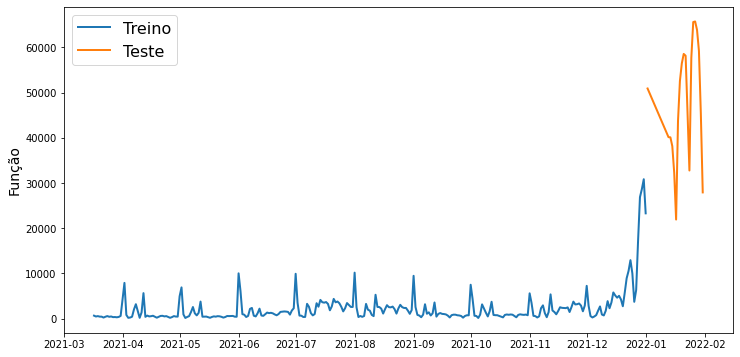

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(df_train[target_name], label='Treino', linewidth=2)
ax.plot(df_test[target_name], label='Teste', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

In [ ]:
# Normalização dos dados
scaler = MinMaxScaler();

X_train_scaler = scaler.fit_transform(df_train[target_name].values.reshape(-1,1))
X_test_scaler = scaler.fit_transform(df_test[target_name].values.reshape(-1,1))

In [ ]:
print(X_test_scaler.shape,X_train_scaler.shape)

(20, 1) (290, 1)


In [ ]:
# Define generator
n_input = 10
n_features = 1
batch_size_train = 2 # Precisa ser divisível pelo número de amostras do X Trains e X Test, pôs define o número de amostras para fazer o gradiente
generator_train = TimeseriesGenerator(X_train_scaler, X_train_scaler, length=n_input, batch_size=batch_size_train)

In [ ]:
# Separando o X de treino e o Y de treino
X_train = []
y_train = []
for i in range(len(generator_train)):
  X, y = generator_train[i]
  X_train.append(X)
  y_train.append(y)


In [ ]:
# Define generator
batch_size_test = 10 # Precisa ser divisível pelo número de amostras do X Trains e X Test, pôs define o número de amostras para fazer o gradiente
generator_test = TimeseriesGenerator(X_test_scaler, X_test_scaler, length=n_input)

In [ ]:
# Separando o X de teste e o Y de teste
X_test = []
y_test = []
for i in range(len(generator_test)):
  X, y = generator_test[i]
  X_test.append(X)
  y_test.append(y)


# 3º Implementação do LSTM

In [ ]:
# Define o modelo ‘identity’, ‘logistic’, ‘tanh’, ‘relu’
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(n_features, activation='relu'))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 300)               362400    
                                                                 
 dense_9 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinando o model
model.fit(generator_train, epochs=50, batch_size=31,  shuffle=False) # shuffle False mantem a ordem dos dados na divisão

Epoch 1/50
140/140 [==============================] - 4s 21ms/step - loss: 0.0086
Epoch 2/50
140/140 [==============================] - 3s 22ms/step - loss: 0.0224
Epoch 3/50
140/140 [==============================] - 3s 21ms/step - loss: 0.0090
Epoch 4/50
140/140 [==============================] - 3s 21ms/step - loss: 0.0100
Epoch 5/50
140/140 [==============================] - 3s 22ms/step - loss: 0.0084
Epoch 6/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0081
Epoch 7/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0103
Epoch 8/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0084
Epoch 9/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0071
Epoch 10/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0063
Epoch 11/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0058
Epoch 12/50
140/140 [==============================] - 3s 23ms/step - loss: 0.0059
Epoch 13/50
1

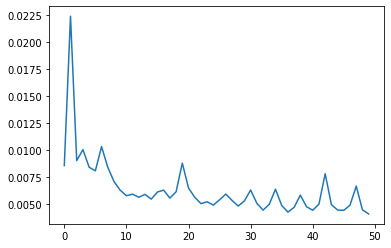

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# 4ª Avaliação do modelo

In [ ]:
# Estimando a performace do modelo
score_treino = model.evaluate(generator_train, verbose=0)
print(f'Score em Treino: {score_treino} MSE, ({sqrt(score_treino)} RMSE)')
score_teste = model.evaluate(X_test, y_test, verbose=0)
print(f'Score em Teste: {score_teste} MSE, ({sqrt(score_teste)} RMSE)')

Score em Treino: 0.003892518812790513 MSE, (0.06239005379698364 RMSE)
Score em Teste: 0.06278476864099503 MSE, (0.2505688900103024 RMSE)


In [ ]:
# Gerando previsões para mostrar no gráfico
previsoes = model.predict(X_test, batch_size=30)
previsoes = scaler.inverse_transform(previsoes)

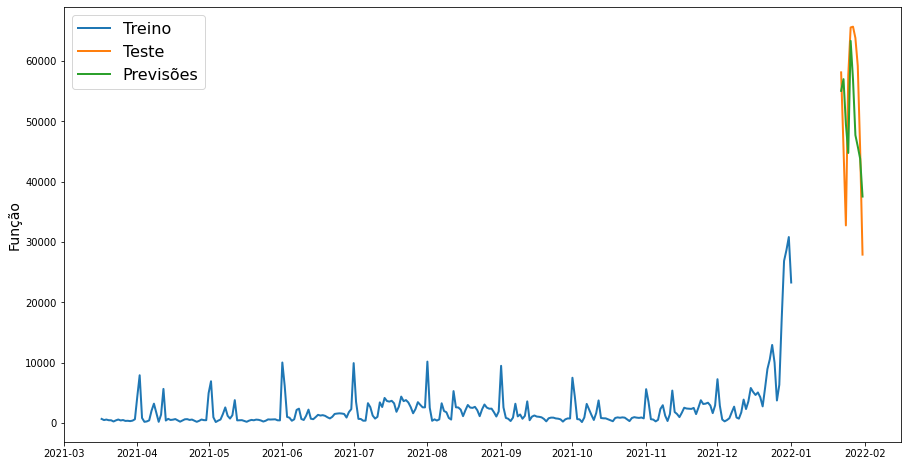

In [ ]:
# Gerando gráfico comparativo
previsto = df_test[n_input:].copy()
previsto['y'] = previsoes
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(df_train[target_name], label='Treino', linewidth=2)
ax.plot(df_test[target_name][n_input:], label='Teste', linewidth=2)
ax.plot(previsto['y'] , label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

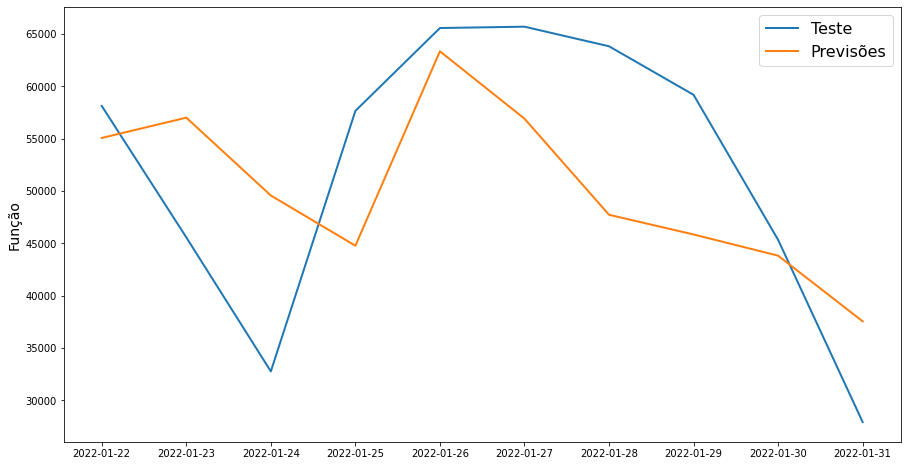

In [ ]:
# Gerando uma visão mais próxima das previsões
previsto = df_test[n_input:].copy()
previsto['y'] = previsoes
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(df_test[target_name][n_input:], label='Teste', linewidth=2)
ax.plot(previsto['y'] , label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

### Realizando previsão do teste

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape_modelo = mape(df_test[target_name][n_input:],previsto['y'])
print(f'O valor do MAPE foi de: {mape_modelo}')

O valor do MAPE foi de: 0.2064399038777586
